In [1]:
import random
import string

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import pandas as pd
import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
from models.kernels import CustomRBFKernel
from models.gp_regression import HealpixGPRegressionModel

In [3]:
# Load plot settings

import sys
sys.path.append("../../spectral_distortions_perturbations/notebooks/")

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
import torch
import gpytorch
import pyro
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS, TracePosterior
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints

pyro.set_rng_seed(101)

In [5]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [7]:
nside = 128

In [8]:
npix = hp.nside2npix(nside)
pixarea = hp.nside2pixarea(nside, degrees=False)
pixarea_deg = hp.nside2pixarea(nside, degrees=True)

Loading the psf correction from: /Users/smsharma/PycharmProjects/fermi-gce-gp/notebooks/psf_dir/Fermi_PSF_2GeV.npy


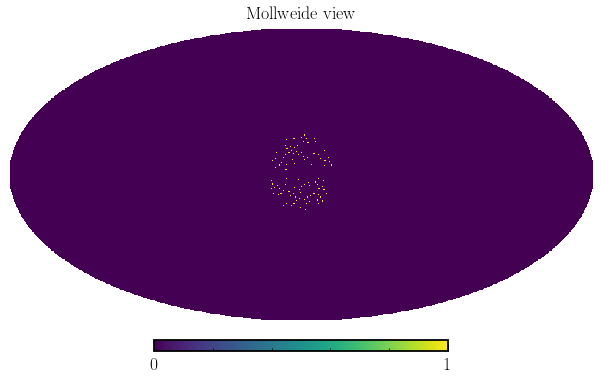

In [54]:
from inference.constructor import ModelConstructor

mc = ModelConstructor(nside=nside, dif_sim='mO', dif_fit='p6', theta_poiss=[0.5, 0.1, 0.5, 0.9, 8.0, 4.0], 
                      theta_ps=[0, 20.0, 1.8, -20.0, 20.0, 0.1],
                      guide_name="MVN", num_inducing=200,
                     kernel="matern52", gp_mean="zero", r_outer=20, mask_ps=True, mask_plane=True, 
                     run_prefix="test_20_MVN_full_1_1_1_[0.5, 0.01]", mode="full", outputscale_prior=[0.5, 0.01], lengthscale_prior=[0.2, 0.001])




In [55]:
from inference.trainer import PyroSVITrainer

trainer = PyroSVITrainer(mc.model, mc.train_x, mc.train_y, mc.save_dir, optimizer_kwargs={"lr": 1e-3})

In [49]:
np.mean(0.9 * mc.temp_gce[~mc.mask]) / np.mean(mc.fermi_exp[~mc.mask]) / pixarea, np.mean(mc.sim.ps_map[~mc.mask]) / np.mean(mc.fermi_exp[~mc.mask]) / pixarea, torch.max(mc.train_y), len(mc.train_y)

(3.004472327927885e-07, 0.0, tensor(89.), 4234)

In [16]:
pyro.clear_param_store()

In [18]:
# trainer.train(num_iter=10000, batch_size=100, decay_every_steps=1000, save_every_steps=1000, num_particles=1, vectorize_particles=False)

In [56]:
for name in pyro.get_param_store().get_all_param_names():
    print(name)
#     print(name, pyro.param(name).data.numpy())

In [57]:
mc.model.state_dict().keys()

odict_keys(['variational_strategy.inducing_points', 'variational_strategy.variational_params_initialized', 'variational_strategy.updated_strategy', 'variational_strategy._variational_distribution.variational_mean', 'variational_strategy._variational_distribution.chol_variational_covar', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'covar_module.base_kernel.lengthscale_prior.loc', 'covar_module.base_kernel.lengthscale_prior.scale', 'covar_module.outputscale_prior.loc', 'covar_module.outputscale_prior.scale', 'mvn.loc_unconstrained', 'mvn.scale_tril_unconstrained'])

In [58]:
mm = ((8. * mc.temp_mO_pibrem +  4. * mc.temp_mO_ics)/ (mc.temp_p6))[~mc.mask]

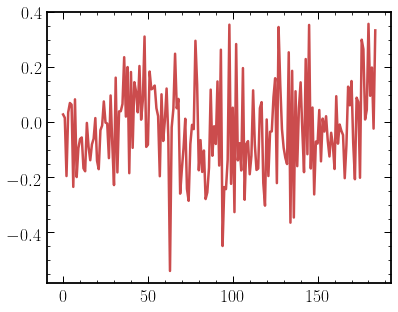

In [59]:
trainer.load_checkpoint(2001)
plt.plot(mc.model.state_dict()['variational_strategy._variational_distribution.variational_mean'])
# trainer.load_checkpoint(10001)
# plt.plot(mc.model.state_dict()['variational_strategy._variational_distribution.variational_mean'])

(2.5, 8.0)

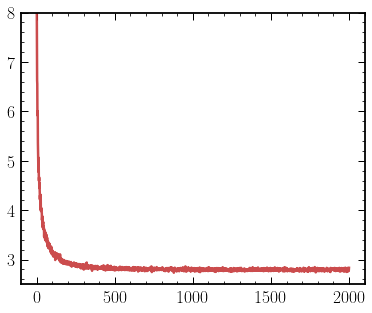

In [60]:
plt.plot(trainer.loss)
plt.ylim(2.5, 8)

In [61]:
mc.model.state_dict()['variational_strategy._variational_distribution.chol_variational_covar']
mc.model.state_dict()['covar_module.raw_outputscale']
mc.model.covar_module.outputscale

tensor(0.4947, grad_fn=<SoftplusBackward>)

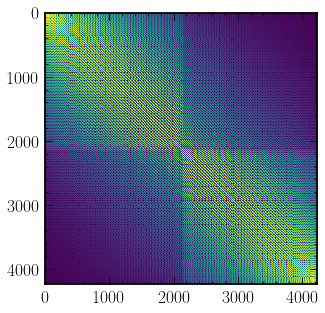

In [62]:
plt.imshow(mc.model.covar_module(mc.train_x).numpy())

In [63]:
mc.model.eval()
with torch.no_grad():
    predictive = Predictive(mc.model.model, guide=mc.model.guide, num_samples=30)
    pred = predictive(mc.train_x, mc.train_y, torch.arange(len(mc.train_x)))
pred.keys()
lower, median, upper = (mc.opt.x[-1]) * np.percentile((pred[mc.run_prefix + '.f(x)']).exp(), [5, 50, 95], axis=0)

In [64]:
# Here's a quick helper function for getting smoothed percentile values from samples
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]
    return percentile_samples

In [65]:
test_x = mc.train_x

mc.model.eval()
with torch.no_grad():
    output = mc.model(test_x)

samples = output(torch.Size([100])).exp()
lower, median, upper = percentiles_from_samples(samples, percentiles=[0.025, 0.5, 0.975])

lower = mc.opt.x[-1] * lower.detach().numpy()
median = mc.opt.x[-1] * median.detach().numpy()
upper = mc.opt.x[-1] * upper.detach().numpy()

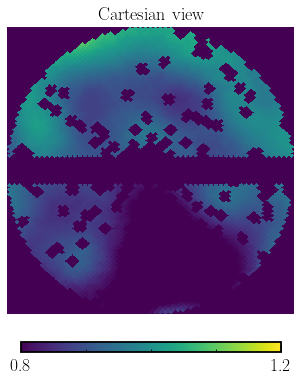

In [66]:
fwd = median / (mc.opt.x[-1])
fwd_map = np.zeros(hp.nside2npix(nside))
fwd_map[~mc.mask] = fwd
rpm = hp.cartview(fwd_map, min=0.8, max=1.2, lonra=[-20, 20], latra=[-20, 20], return_projected_map=True)
rpm.mask = (rpm.data == 0)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


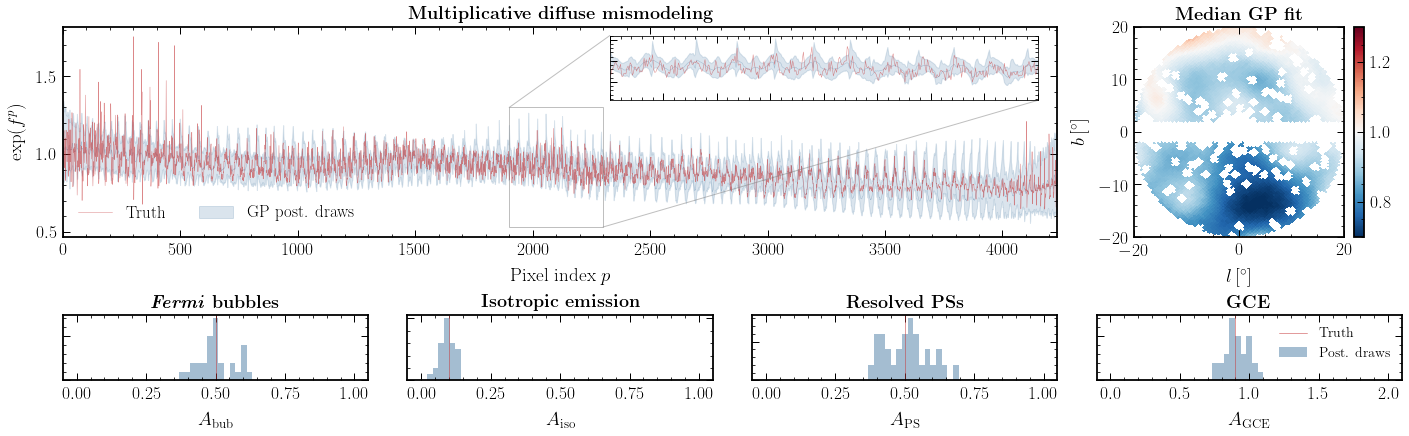

In [67]:
lw_truth = 0.5
fs_title = 18.

fig = plt.figure(constrained_layout=False, figsize=(24, 6.5))
ax = [None] * 6
gs = fig.add_gridspec(nrows=3, ncols=4, wspace=0.128, hspace=1.2)
ax[0] = fig.add_subplot(gs[:-1, : -1])
ax[1] = fig.add_subplot(gs[-1, 0])
ax[2] = fig.add_subplot(gs[-1, 1])
ax[3] = fig.add_subplot(gs[-1, 2])
ax[4] = fig.add_subplot(gs[-1, 3])
ax[5] = fig.add_subplot(gs[:-1, 3])

ax[0].fill_between(np.arange(len(lower)), lower / mc.opt.x[-1], upper / mc.opt.x[-1], alpha=0.2, color=cols_default[1], label="GP post. draws")
ax[0].plot(median / mc.opt.x[-1], color=cols_default[1], lw=lw_truth, alpha=0.4)
ax[0].plot(mm / mc.opt.x[-1], color=cols_default[0], label="Truth", lw=lw_truth, alpha=0.6)
# ax[0].plot(mm2 / np.mean(mm2), color=cols_default[3], label="Truth", lw=lw_truth, alpha=0.6)
# ax[0].plot(mm3 / np.mean(mm3), color=cols_default[3], label="Truth", lw=lw_truth, alpha=0.6)
# ax[0].axhline(13, color=cols_default[0], label="Truth", lw=lw_truth)

ax[0].set_xlabel("Pixel index $p$")
ax[0].set_ylabel(r"$\exp(f^{p})$")
ax[0].set_title(r"\bf{Multiplicative diffuse mismodeling}", fontsize=fs_title)
ax[0].legend(loc='lower left', ncol=2)

# inset axes....
axins = ax[0].inset_axes([0.55, 0.65, 0.43, 0.31])
axins.fill_between(np.arange(len(lower)), lower / mc.opt.x[-1], upper / mc.opt.x[-1], alpha=0.2, color=cols_default[1], label="GP post. draws")
axins.plot(median / mc.opt.x[-1], color=cols_default[1], lw=lw_truth, alpha=0.4)
axins.plot(mm / mc.opt.x[-1], color=cols_default[0], label="Truth", lw=lw_truth, alpha=0.6)

# sub region of the original image
x1, x2, y1, y2 = 1900, 2300, 0.53, 1.3
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels(r'')
axins.set_yticklabels(r'')

for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(0.8)

ax[0].indicate_inset_zoom(axins)


# ax[0].set_xlim(2000, 2400)
ax[0].set_xlim(0, len(mc.train_x))
# ax[0].set_ylim(8, 16)

ax[1].hist((pred['bub'].detach().numpy()), label="Post. draws", color=cols_default[1], alpha=0.5, bins=np.linspace(0., 1., 50));
ax[1].axvline(.5, label="Truth", color=cols_default[0], lw=lw_truth)
ax[1].set_xlabel(r"$A_\mathrm{bub}$")
ax[1].set_title(r"\bf{\emph{Fermi} bubbles}", fontsize=fs_title)
# ax[1].legend()
ax[1].get_yaxis().set_ticklabels([])

ax[2].hist((pred['iso'].detach().numpy()), label="Post. draws", color=cols_default[1], alpha=0.5, bins=np.linspace(0., 1., 50));
ax[2].axvline(.1, label="Truth", color=cols_default[0], lw=lw_truth)
ax[2].set_xlabel(r"$A_\mathrm{iso}$")
ax[2].set_title(r"\bf{Isotropic emission}", fontsize=fs_title)
# ax[2].legend()
ax[2].get_yaxis().set_ticklabels([])

ax[3].hist((pred['psc'].detach().numpy()), label="Post. draws", color=cols_default[1], alpha=0.5, bins=np.linspace(0., 1., 50));
ax[3].axvline(.5, label="Truth", color=cols_default[0], lw=lw_truth)
ax[3].set_xlabel(r"$A_\mathrm{PS}$")
ax[3].set_title(r"\bf{Resolved PSs}", fontsize=fs_title)
# ax[3].legend()
ax[3].get_yaxis().set_ticklabels([])

ax[4].hist((pred['gce'].detach().numpy()), label="Post. draws", color=cols_default[1], alpha=0.5, bins=np.linspace(0., 2., 50));
ax[4].axvline(.9, label="Truth", color=cols_default[0], lw=lw_truth)
ax[4].set_xlabel(r"$A_\mathrm{GCE}$")
ax[4].set_title(r"\bf{GCE}", fontsize=fs_title)
ax[4].legend(fontsize=14)
ax[4].get_yaxis().set_ticklabels([])

im = ax[5].imshow(rpm, origin='lower', vmin=0.7, vmax=1.3, cmap='RdBu_r', extent=[-20, 20, -20, 20])
ax[5].set_title(r"\bf{Median GP fit}", fontsize=fs_title)
ax[5].set_xlabel("$l\,[^\circ]$")
ax[5].set_ylabel("$b\,[^\circ]$")

from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
plt.colorbar(im, cax=cax)

# ax[5].hist((dif_mean), label="Post. draws", color=cols_default[1], alpha=0.5, bins=np.linspace(5., 15., 200));
# ax[5].axvline(13., label="Truth", color=cols_default[0], lw=lw_truth)
# ax[5].set_xlabel("Dif norm.")
# ax[5].set_title(r"\bf{Dif template}", fontsize=fs_title)
# ax[5].legend()
# ax[5].set_xlim(11, 15)

# ax[5].hist((pred['dif'].detach().numpy()), label="Post. draws", color=cols_default[1], alpha=0.5, bins=np.linspace(5., 15., 200));
# # ax[5].axvline(.5, label="Truth", color=cols_default[0], lw=lw_truth)
# ax[5].set_xlabel("Dif norm.")
# ax[5].set_title(r"\bf{Dif template}", fontsize=fs_title)
# ax[5].legend()

plt.tight_layout()
# plt.savefig("../drafts/ml4ps/figures/inference.pdf", bbox_inches='tight')

bub 1.4200081e-07
iso 2.476098e-08
psc 5.192027e-10
gce 6.240152e-07
gcePS 7.690934655284279e-08
dskPS 4.0057646898257527e-07


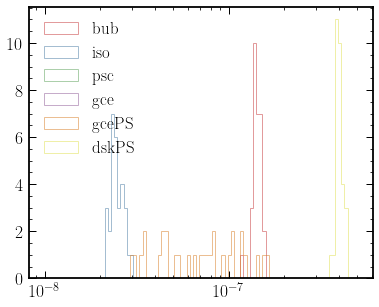

In [106]:
total_inten = 0.

# ph/cm^2/s/sr

from scipy.ndimage import gaussian_filter1d
sigma_smooth = 0.9

bins = np.logspace(-8, np.log10(5e-7), 100)
s_ary = np.logspace(-2, 2, 1000)

intensity_ary = []
labels_ary = []

for ip, poiss_key in enumerate(mc.model.poiss_labels):
    intensity = pred[poiss_key].detach().numpy().flatten() * np.mean(mc.model.poiss_temps[ip].detach().numpy()) / np.mean(mc.fermi_exp[~mc.mask]) / pixarea
    plt.hist(gaussian_filter1d(intensity, sigma=sigma_smooth), bins=bins, label=poiss_key, alpha=0.5, histtype='step');
    intensity_ary.append(intensity)
    total_inten += np.median(intensity)
    print(poiss_key, np.mean(intensity))
    labels_ary.append(poiss_key)
    
for ip, ps_key in enumerate(mc.model.ps_labels):
    samples = np.transpose([pred[var + '_' + ps_key].detach().numpy() for var in mc.model.ps_param_labels])[0]
    samples[:,0] = samples[:,0]
    samples[:,-1] = samples[:,-1]
    samples[:,-1] = samples[:,-1] * samples[:,-2]
    dnds_ary = [dnds(torch.tensor(s_ary), torch.tensor(s)).detach().numpy() for s in samples]

    intensity_ps = np.trapz(s_ary * dnds_ary, s_ary, axis=1) * np.mean((mc.model.ps_temps[ip].detach().numpy())) / np.mean(mc.fermi_exp[~mc.mask]) / pixarea
    plt.hist(gaussian_filter1d(intensity_ps, sigma=sigma_smooth), bins=bins, label=ps_key + 'PS', alpha=0.5, histtype='step');
    
    intensity_ary.append(intensity_ps)
    total_inten += np.median(intensity_ps)
    print(ps_key + 'PS', np.mean(intensity_ps))
    labels_ary.append(ps_key + 'PS')
    
# intensity_dif = 13. * np.mean((pred['test.f(x)']).exp().detach().numpy(), axis=1) * np.mean(mc.temp_dif_fit[~mc.mask]) / np.mean(mc.fermi_exp[~mc.mask]) / pixarea

# print('dif', np.mean(intensity_dif))
# # plt.xlim(0, 3)
# plt.hist(intensity_dif, bins=bins, label='difGP', histtype='step');
# total_inten += np.median(intensity_dif)
# intensity_ary.append(intensity_dif)
# plt.xlabel(r"Intensity\,[ph\,cm$^{-2}$\,s$^{-1}$\,sr$^{-1}$]")

plt.gca().set_xscale("log")

plt.legend(loc='upper left')

In [107]:
for key in pred.keys():
    print(key, np.median(pred[key].detach().numpy()))

bub 0.5340164
iso 0.108686894
psc 0.5447386
gce 1.3738887
A_ps_gce 0.20331532
n_1_gce 15.40147
n_2_gce 1.7911139
n_3_gce -7.4193344
Sb_1_gce 4.868903
Sb_2_gce 0.021397047
A_ps_dsk 0.12444171
n_1_dsk 14.980225
n_2_dsk 1.7707958
n_3_dsk -4.460882
Sb_1_dsk 24.263
Sb_2_dsk 0.027451627
.u -0.0025647879
test_np_200_15.0_IAF_only_gp_1_1_1_[0.5, 0.02]_[0.2, 0.02].f(x) -0.10612706
.log_prior nan
.added_loss nan
test_np_200_15.0_IAF_only_gp_1_1_1_[0.5, 0.02]_[0.2, 0.02].log_likelihood nan


/Users/smsharma/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/smsharma/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/smsharma/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [108]:
mc.model.guide(mc.train_x, mc.train_y, torch.arange(len(test_x)))

/Users/smsharma/anaconda3/lib/python3.7/site-packages/gpytorch/distributions/multivariate_normal.py:229: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  NumericalWarning,


In [109]:
mc.model.templates_guide_iaf(torch.arange(len(test_x)))

{'bub': tensor(0.5218, grad_fn=<ExpandBackward>),
 'iso': tensor(0.0950, grad_fn=<ExpandBackward>),
 'psc': tensor(0.5420, grad_fn=<ExpandBackward>),
 'gce': tensor(1.3354, grad_fn=<ExpandBackward>),
 'A_ps_gce': tensor(0.2506, grad_fn=<ExpandBackward>),
 'n_1_gce': tensor(15.1289, grad_fn=<ExpandBackward>),
 'n_2_gce': tensor(1.7908, grad_fn=<ExpandBackward>),
 'n_3_gce': tensor(0.3965, grad_fn=<ExpandBackward>),
 'Sb_1_gce': tensor(5.5724, grad_fn=<ExpandBackward>),
 'Sb_2_gce': tensor(0.0208, grad_fn=<ExpandBackward>),
 'A_ps_dsk': tensor(0.1461, grad_fn=<ExpandBackward>),
 'n_1_dsk': tensor(12.4221, grad_fn=<ExpandBackward>),
 'n_2_dsk': tensor(1.4967, grad_fn=<ExpandBackward>),
 'n_3_dsk': tensor(-3.0730, grad_fn=<ExpandBackward>),
 'Sb_1_dsk': tensor(19.6496, grad_fn=<ExpandBackward>),
 'Sb_2_dsk': tensor(0.0208, grad_fn=<ExpandBackward>)}

In [110]:
1.5 * npix

294912.0

In [111]:
theta = torch.tensor([1.5 * npix, 20.0, 1.8, -20.0, 20.0, 0.1])

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


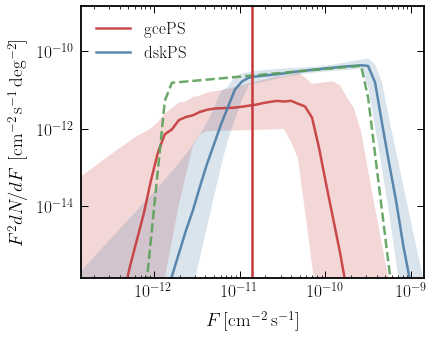

In [112]:
from models.scd import dnds

s_ary = np.logspace(-2, 2)

s_ary = torch.tensor(s_ary)

for ip, ps_key in enumerate(mc.model.ps_labels):
    samples = np.transpose([pred[var + '_' + ps_key].detach().numpy() for var in mc.model.ps_param_labels])[0]
    samples[:,0] = samples[:,0]
    samples[:,-1] = samples[:,-1]
    samples[:,-1] = samples[:,-1] * samples[:,-2]
    dnds_ary = np.array([dnds(s_ary, samp).detach().numpy() for samp in torch.tensor(samples)]) * (np.mean(mc.model.ps_temps[ip].detach().numpy())) / pixarea_deg
    plt.plot(s_ary / np.mean(mc.fermi_exp[~mc.mask]), s_ary ** 2 * np.median(dnds_ary, axis=0) / np.mean(mc.fermi_exp[~mc.mask]), label=ps_key + "PS")
    plt.fill_between(s_ary / np.mean(mc.fermi_exp[~mc.mask]), s_ary ** 2 * np.percentile(dnds_ary, [5.], axis=0)[0] / np.mean(mc.fermi_exp[~mc.mask]), s_ary ** 2 * np.percentile(dnds_ary, [95.], axis=0)[0] / np.mean(mc.fermi_exp[~mc.mask]), alpha=0.2)
    
dnds_fit_ary = dnds(torch.tensor(s_ary), theta).detach().numpy() * np.mean(mc.model.ps_temps[0].detach().numpy())

plt.plot(s_ary / np.mean(mc.fermi_exp[~mc.mask]), s_ary ** 2 * (dnds_fit_ary) / npix / np.mean(mc.fermi_exp[~mc.mask]) / pixarea_deg, ls='--')

plt.xlim(1e-2 / np.mean(mc.fermi_exp[~mc.mask]), 1e2 / np.mean(mc.fermi_exp[~mc.mask]))
plt.ylim(1e-5 / np.mean(mc.fermi_exp[~mc.mask]), 1e2 / np.mean(mc.fermi_exp[~mc.mask]))

plt.axvline(1 / np.mean(mc.fermi_exp[~mc.mask]))

plt.xlabel(r"$F$\,[cm$^{-2}$\,s$^{-1}$]")
plt.ylabel(r"$F^2 dN/dF$ [cm$^{-2}$\,s$^{-1}$\,deg$^{-2}$]")

plt.xscale("log")
plt.yscale("log")
plt.legend()

- Inferred flux fraction and total intensity plots
- SCDs
- Map posteriors
- Corner plots for various params
- Model comparison and information criteria
- Pixel-wise likelihoods
